In [246]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [247]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [248]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [249]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [250]:
train.year.sample(5)

1488    2011
7272    2012
771     2011
8998    2012
2368    2011
Name: year, dtype: int64

In [251]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [283]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
# onehotencoding 과 점수 차이 없음.
categorical_feature_names = ["season","holiday","workingday","weather",'hour',
                             "dayofweek","month","year"]


In [284]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
train_encoded=train[categorical_feature_names].apply(encoder.fit_transform)
train_encoded.head()

,season,holiday,workingday,weather,hour,dayofweek,month,year
0,0,0,0,0,0,5,0,0
1,0,0,0,0,1,5,0,0
2,0,0,0,0,2,5,0,0
3,0,0,0,0,3,5,0,0
4,0,0,0,0,4,5,0,0


In [285]:
test_encoded=test[categorical_feature_names].apply(encoder.fit_transform)
test_encoded.head()

,season,holiday,workingday,weather,hour,dayofweek,month,year
0,0,0,1,0,0,3,0,0
1,0,0,1,0,1,3,0,0
2,0,0,1,0,2,3,0,0
3,0,0,1,0,3,3,0,0
4,0,0,1,0,4,3,0,0


In [286]:
train[categorical_feature_names]=train_encoded

In [287]:
test[categorical_feature_names]=test_encoded

In [288]:
feature_names = ["season", "weather","atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [289]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 9)


,season,weather,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,0,0,14.395,81,0,0,5,0,0
1,0,0,13.635,80,0,1,5,0,0
2,0,0,13.635,80,0,2,5,0,0
3,0,0,14.395,75,0,3,5,0,0
4,0,0,14.395,75,0,4,5,0,0


In [290]:
X_test= test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 9)


,season,weather,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,0,0,11.365,56,0,0,3,0,1
1,0,0,13.635,56,0,1,3,0,1
2,0,0,13.635,56,0,2,3,0,1
3,0,0,12.880,56,0,3,3,0,1
4,0,0,12.880,56,0,4,3,0,1


In [291]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [292]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

### 1. 선형회귀

In [293]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9804701634207615


### 2. 릿지회귀(overfit 제어, l2규제로 가중치를 0에 가깝게)

In [294]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9804701613377745


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003590,0.000492,0.001789,3.963507e-04,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003555,-0.906011,-1.029700,-1.015862,-0.980816,-0.987189,0.043652,1
1,0.002992,0.000631,0.001197,3.988987e-04,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003558,-0.906011,-1.029700,-1.015861,-0.980818,-0.987190,0.043653,2
2,0.002593,0.000798,0.000997,4.264961e-07,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003585,-0.906008,-1.029699,-1.015852,-0.980834,-0.987196,0.043654,3
3,0.002793,0.000399,0.001795,3.988981e-04,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003615,-0.906006,-1.029699,-1.015842,-0.980853,-0.987203,0.043655,4
4,0.002194,0.000399,0.000997,2.780415e-07,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003645,-0.906004,-1.029698,-1.015832,-0.980871,-0.987210,0.043656,5


### 3. 라쏘회귀(overfit 제어, l1규제로 가중치를 0으로 만들며 feature selection 가능)

In [295]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.980480620612985


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.061681
3,0.333333,1.059981
4,0.250000,1.060063


### 점수가 엄청 저조함=> 대부분의 feature가 label과 선형 관계가 아님

###  4. GAM

In [314]:
train_scaled=train[['atemp','windspeed','humidity']]
train_scaled.head()
test_scaled=test[['atemp','windspeed','humidity']]

In [315]:
from sklearn.preprocessing import QuantileTransformer
scaler=QuantileTransformer()

train_scaled=scaler.fit_transform(train_scaled)
test_scaled=scaler.fit_transform(test_scaled)


In [316]:
train_scaled=pd.DataFrame(train_scaled)
test_scaled=pd.DataFrame(test_scaled)
train_scaled.head()

,0,1,2
0,0.167668,0.0,0.796296
1,0.134635,0.0,0.785786
2,0.134635,0.0,0.785786
3,0.167668,0.0,0.711211
4,0.167668,0.0,0.711211


In [322]:
train[['atemp','windspeed','humidity']]=train_scaled
test[['atemp','windspeed','humidity']]=test_scaled

In [323]:
feature_names = ["season", "weather","atemp", "humidity",
                 "year", "hour",  "workingday"
                ]

X_train = train[feature_names]

print(X_train.shape)
X_train.head()




label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886, 7)
(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [324]:
from pygam import LinearGAM,s,f,te
y_train_log = np.log1p(y_train)
from sklearn.model_selection import train_test_split

X= X_train.values
y=y_train_log.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

n=5
gam = LinearGAM(f(0)+f(1)+s(2)+s(3)+f(4)+f(5)+te(5,6)+f(6)).gridsearch(X_train, y_train, lam=np.logspace(-3,3, n))


100% (5 of 5) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [325]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     78.9596
Link Function:                     IdentityLink Log Likelihood:                                -24017.0075
Number of Samples:                         8708 AIC:                                            48193.9341
                                                AICc:                                           48195.4348
                                                GCV:                                                 0.129
                                                Scale:                                              0.1269
                                                Pseudo R-Squared:                                   0.9376
Feature Function                  Lam

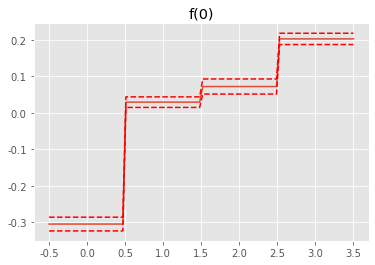

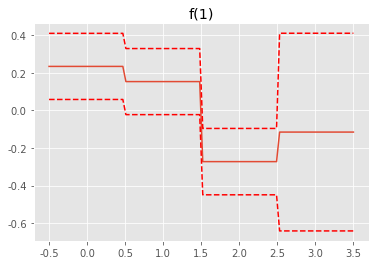

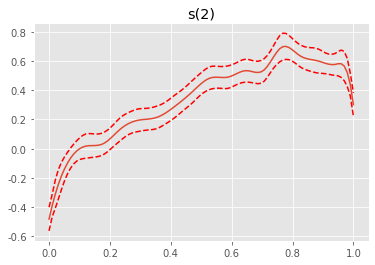

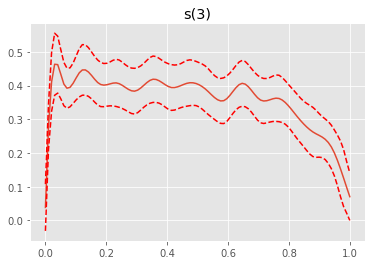

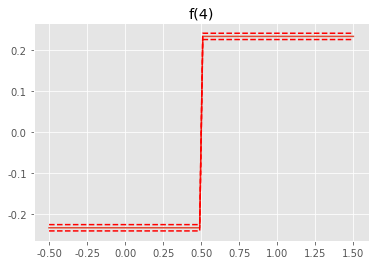

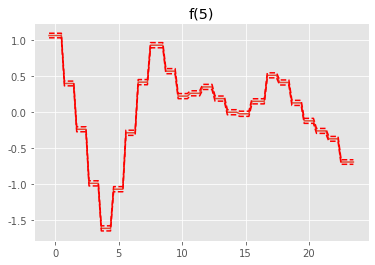

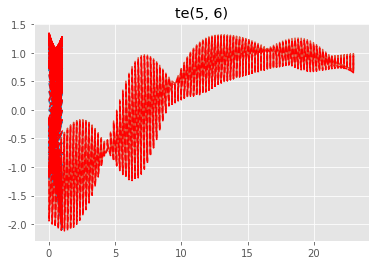

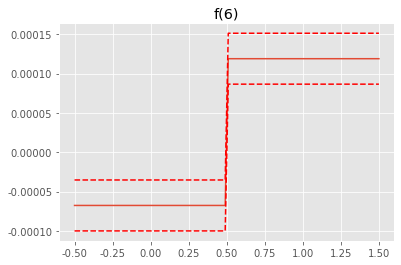

In [326]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

* summary
* GCV:
* R-Squared:
1. rank:
2. EDOF:(자유도)
3. Pvalue


0.3478962801925364

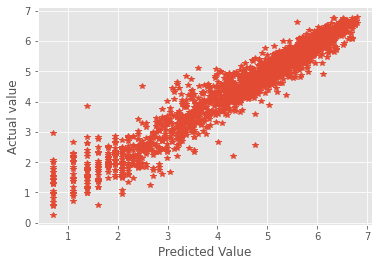

In [327]:
plt.plot(y_test, gam.predict(X_test),"*")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")
E_score=rmsle(y_test, gam.predict(X_test))
E_score

### 

In [328]:
print(feature_names)
X_test_sub= test[feature_names]

print(X_test_sub.shape)
X_test_sub.head()

['season', 'weather', 'atemp', 'humidity', 'year', 'hour', 'workingday']
(6493, 7)


,season,weather,atemp,humidity,year,hour,workingday
0,0,0,0.084084,0.362362,0,0,1
1,0,0,0.152152,0.362362,0,1,1
2,0,0,0.152152,0.362362,0,2,1
3,0,0,0.115115,0.362362,0,3,1
4,0,0,0.115115,0.362362,0,4,1


# submission

In [329]:
gam.predict(X_test_sub)

array([2.68974025, 1.89649871, 1.34656701, ..., 4.75040956, 4.48722291,
       4.05981604])

In [330]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = gam.predict(X_test_sub)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,2.689740
1,2011-01-20 01:00:00,1.896499
2,2011-01-20 02:00:00,1.346567
3,2011-01-20 03:00:00,0.969122
4,2011-01-20 04:00:00,1.032124


In [331]:
submission.to_csv("Score_{0:.5f}_submission.csv".format(E_score), index=False)

In [332]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = gam.predict(X_test_sub)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,2.689740
1,2011-01-20 01:00:00,1.896499
2,2011-01-20 02:00:00,1.346567
3,2011-01-20 03:00:00,0.969122
4,2011-01-20 04:00:00,1.032124
